In [1]:
# !python -m pip install elasticsearch
# !wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
# !tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
# !chown -R daemon:daemon elasticsearch-7.9.2

In [38]:
import os
from subprocess import Popen, PIPE, STDOUT
# es_server.kill()
es_server = Popen(['/opt/ml/elasticsearch-7.9.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)
                  )
! sleep 30

In [3]:
# ! /opt/ml/elasticsearch-7.9.2/bin/elasticsearch-plugin install analysis-nori

In [4]:
# es_server.kill()

In [39]:
from elasticsearch import Elasticsearch
es = Elasticsearch('localhost:9200')

In [40]:
es.info()

{'name': '640277a98ae6',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'JL4mg3SiSJudLDB6M5KTlQ',
 'version': {'number': '7.9.2',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_date': '2020-09-23T00:45:33.626720Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [8]:
es.indices.create(index = 'document_dy',
                  body = {
                      'settings':{
                          'analysis':{
                              'analyzer':{
                                  'my_analyzer':{
                                      "type": "custom",
                                      'tokenizer':'nori_tokenizer',
                                      'decompound_mode':'mixed',
                                      'stopwords':'_korean_',
                                      "filter": ["lowercase",
                                                 "my_shingle_f",
                                                 "nori_readingform",
                                                 "nori_number"]
                                  }
                              },
                              'filter':{
                                  'my_shingle_f':{
                                      "type": "shingle"
                                  }
                              }
                          },
                          'similarity':{
                              'my_similarity':{
                                  'type':'BM25',
                              }
                          }
                      },
                      'mappings':{
                          'properties':{
                              'title':{
                                  'type':'text',
                                  'analyzer':'my_analyzer',
                                  'similarity':'my_similarity'
                              },
                              'text':{
                                  'type':'text',
                                  'analyzer':'my_analyzer',
                                  'similarity':'my_similarity'
                              },
                              'document_id':{
                                  'type':'text'
                              }
                          }
                      }
                  }
                  )

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'document_dy'}

In [9]:
es.indices.get('document_dy')

{'document_dy': {'aliases': {},
  'mappings': {'properties': {'document_id': {'type': 'text'},
    'text': {'type': 'text',
     'analyzer': 'my_analyzer',
     'similarity': 'my_similarity'},
    'title': {'type': 'text',
     'analyzer': 'my_analyzer',
     'similarity': 'my_similarity'}}},
  'settings': {'index': {'number_of_shards': '1',
    'provided_name': 'document_dy',
    'similarity': {'my_similarity': {'type': 'BM25'}},
    'creation_date': '1621412824922',
    'analysis': {'filter': {'my_shingle_f': {'type': 'shingle'}},
     'analyzer': {'my_analyzer': {'filter': ['lowercase',
        'my_shingle_f',
        'nori_readingform',
        'nori_number'],
       'decompound_mode': 'mixed',
       'type': 'custom',
       'stopwords': '_korean_',
       'tokenizer': 'nori_tokenizer'}}},
    'number_of_replicas': '1',
    'uuid': 'AWISGyQHQUugGR6p_LljRQ',
    'version': {'created': '7090299'}}}}}

In [10]:
import json
import pandas as pd

# with open("input/data/wikipedia_documents.json", 'r') as f:
#     wiki_data = pd.DataFrame(json.load(f)).transpose()
    
with open("code/sparse-mecab-koreanwiki/wikipedia_documents_kor_v3.json", 'r') as f:
    wiki_data = pd.DataFrame(json.load(f)).transpose()

In [11]:
from tqdm import tqdm

for num in tqdm(range(len(wiki_data))):
    es.index(index='document_dy', body = {"title" : wiki_data['title'][num], "text" : wiki_data['text'][num], "document_id" : wiki_data['document_id'][num]})

100%|██████████| 60045/60045 [05:30<00:00, 181.64it/s]


In [12]:
from datasets import (
    Dataset,
    load_from_disk,
    concatenate_datasets,
)
from konlpy.tag import Mecab
# from rank_bm25 import BM25Okapi

In [13]:
org_dataset = load_from_disk("/opt/ml/input/data/train_dataset")
full_ds = concatenate_datasets(
    [
        org_dataset["train"].flatten_indices(),
        org_dataset["validation"].flatten_indices(),
    ]
) # train dev 를 합친 4192 개 질문에 대해 모두 테스트
print("*"*40, "query dataset", "*"*40)
print(full_ds)

Loading cached processed dataset at /opt/ml/input/data/train_dataset/train/cache-5864ec783ab77348.arrow
Loading cached processed dataset at /opt/ml/input/data/train_dataset/validation/cache-ec5c6075463087d0.arrow


**************************************** query dataset ****************************************
Dataset({
    features: ['__index_level_0__', 'answers', 'context', 'document_id', 'id', 'question', 'title'],
    num_rows: 4192
})


In [14]:
import re
from konlpy.tag import Mecab

mecab = Mecab()

# 질문에 특정적인 용어를 삭제하는 함수
def remove_q(query):
    stop = "|".join(
        "어느 무엇인가요 무엇 누가 누구인가요 누구인가 누구 어디에서 어디에 어디서 어디인가요 어디를 어디 언제 어떤 어떠한 몇 얼마 얼마나 뭐 어떻게 무슨 \?".split(
            " "
        )
    )
    rm = re.sub(stop, "", query).strip()
    return rm


# Retriever 에서 사용되는 토크나이저
def process_morphs_simple(query):
    rm = remove_q(query)
    pos = mecab.pos(rm)
    return [x[0] for x in pos if x[1][0] != "J" and x[1][0] != "E" and x[1][0] != "X"]

' '.join(process_morphs_simple('현대적 인사조직관리의 시발점이 된 책은?'))

'현대 인사 조직 관리 시발점 된 책'

In [26]:
from pororo import Pororo
mrc = Pororo("mrc", "ko")

In [41]:
count = [0, 0, 0, 0, 0]
topk = [1, 3, 5, 10, 20]
check = []

# for i in range(4):
for j in tqdm(range(200)):
    question = full_ds['question'][j]
#     question = ' '.join(process_morphs_simple(question))
    ground_truth = full_ds['context'][j]
    ground_truth_did = full_ds['document_id'][j]
    
    query = {
        'query':{
            'bool':{
                'must':[
                          {'match':{'text':question}}
                ],
                'should':[
                          {'match':{'text':question}}
                ]
            }
        }
    }

    doc = es.search(index='document_dy',body=query,size=20)['hits']['hits']
    topk_contexts = []
    for i in range(len(doc)):
        topk_contexts.append(doc[i]['_source']['document_id'])
#     topk_contexts = [print(element) for element in doc[0]]
#     print(topk_contexts)
    for idx, text in enumerate(topk_contexts):
        if text == ground_truth_did:
            check.append(idx)
            if idx == 0:
                count[0] += 1
            elif 0 < idx < 3:
                count[1] += 1
            elif 0 < idx < 5:
                count[2] += 1
            elif 5 < idx < 10:
                count[3] += 1
            elif 10 < idx < 20:
                count[4] += 1
            break

count[4] += (count[0] + count[1] + count[2] + count[3])
count[3] += (count[0] + count[1] + count[2])
count[2] += (count[0] + count[1])
count[1] += count[0]



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:00<01:22,  2.41it/s]

  1%|          | 2/200 [00:00<01:09,  2.86it/s]

  2%|▏         | 3/200 [00:00<01:04,  3.08it/s]

  2%|▏         | 4/200 [00:01<00:57,  3.38it/s]

  2%|▎         | 5/200 [00:01<00:52,  3.73it/s]

  3%|▎         | 6/200 [00:01<00:49,  3.95it/s]

  4%|▎         | 7/200 [00:01<00:40,  4.74it/s]

  4%|▍         | 8/200 [00:01<00:38,  5.03it/s]

  4%|▍         | 9/200 [00:02<00:39,  4.82it/s]

  5%|▌         | 10/200 [00:02<00:38,  4.97it/s]

  6%|▌         | 12/200 [00:02<00:32,  5.81it/s]

  6%|▋         | 13/200 [00:02<00:29,  6.29it/s]

  8%|▊         | 15/200 [00:02<00:26,  6.91it/s]

  8%|▊         | 16/200 [00:02<00:27,  6.78it/s]

  8%|▊         | 17/200 [00:03<00:31,  5.76it/s]

  9%|▉         | 18/200 [00:03<00:30,  5.92it/s]

 10%|▉         | 19/200 [00:03<00:30,  5.85it/s]

 10%|█         | 20/200 [00:03<00:30,  5.85it/s]

 10%|█         | 21/200 [00:03<00:30,  5.94it/s]

 11%|█         |

KeyboardInterrupt: 

In [19]:
import numpy as np

print(count)
print(np.array(count) / len(full_ds))

[2307, 3338, 3533, 3651, 3771]
[0.55033397 0.79627863 0.8427958  0.87094466 0.89957061]


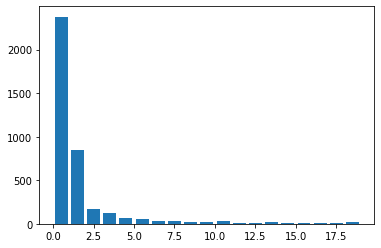

In [17]:
# !pip install matplotlib

import matplotlib.pyplot as plt

plt.hist(check, rwidth=0.8, bins=np.arange(0,20,1))
plt.show()

In [46]:
question = '''유령'은 어느 행성에서 지구로 왔는가?'''
query = {
        'query':{
            'bool':{
                'must':[
                          {'match':{'text':question}}
                ],
                'should':[
                          {'match':{'text':question}}
                ]
            }
        }
    }

doc = es.search(index='document_dy',body=query,size=5)['hits']['hits']
doc
a = []
for idx in range(len(doc)):
    a.append(doc[idx]['_score'])
a

[52.49792, 47.31192, 46.607067, 45.782112, 45.101215]

In [47]:
from scipy.special import softmax

In [48]:
a_softmax = softmax(a)

In [58]:
type(a_softmax.tolist())

list

In [62]:
'[SEP]'.join(map(str, a_softmax.tolist()))

'0.9899188311982309[SEP]0.005537941997119035[SEP]0.0027367468967357837[SEP]0.0011993922271053294[SEP]0.0006070876808059403'

In [51]:
a_softmax.sum()

0.9999999999999969